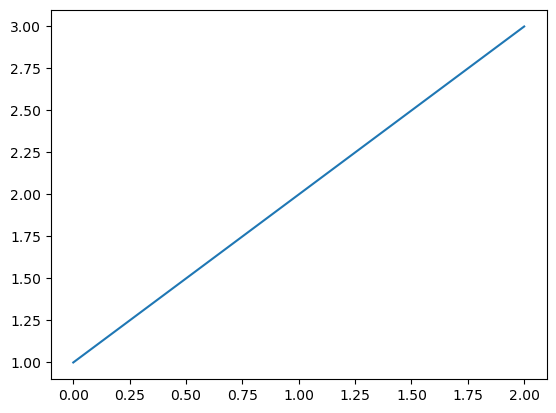

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])

In [2]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import os
from torchvision import io
import pickle
import sys
import numpy as np

Dataloader

In [3]:
class BaseHISDataset(Dataset):
    def __init__(self, 
                 images_dir: str,
                 annotations_dir: str):
        """Base loader for hierarchical dataset

        Args:
            images_dir (str): path to source images folder
            annotations_dir (str): path to annotation tree folder            
        """
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.images = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # read image
        image = io.read_image(str(Path(self.images_dir) / self.images[index])).float()
        image /= 255
        
        
        # read annotations
        with open(str(Path(self.annotations_dir) /
                  self.images[index].replace(".png", ".pkl")), "rb") as f:
            annotation = pickle.load(f)
            

        return image, annotation

In [4]:
def generateAnnotationMask(annotation: tuple, attentionMask: np.ndarray, threshold: float=0.1) -> np.ndarray:
    
    attentionMaskSum = np.sum(attentionMask)
    annotationMask = np.zeros_like(attentionMask)
    
    def _inorder(ann):
        mask = attentionMask & ann[1]
        intersection = np.sum(mask)
        if (attentionMaskSum-intersection)/attentionMaskSum > threshold:
            nonlocal annotationMask
            annotationMask = annotationMask | mask
            return
        
        for child in ann[2]:
            _inorder(child)
            
    _inorder(annotation)
    
    return annotationMask

Model definition

In [5]:
from torch import nn

In [54]:
class ModelSeg1(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
        )
        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 2, 1),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, 2, 1),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 2, 1),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.Conv2d(32, 1, 3, 1, 1),
        )
    
    def forward(self, x):
        x = self.down(x)
        x = self.up(x)
        
        return x

In [63]:
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # no bias for batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=4, 
        out_channels=1,
        features=[64, 128, 256, 512],
        dropout=0.,
    ):
        super().__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = dropout
        
        # downs
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # ups
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    2,
                    2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = nn.functional.dropout2d(x, self.dropout)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            x = nn.functional.dropout2d(x, self.dropout)
            
        return self.final_conv(x)
    
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

In [61]:
# test input
UNet()(torch.rand((8, 4, 200, 200))).shape

torch.Size([8, 1, 200, 200])

Data split

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split

In [8]:
dataset = BaseHISDataset("../data/dataset_3/data/", "../data/dataset_3/treeAnnotations/")

In [9]:
len(dataset)

50

In [42]:
train_dataset, val_dataset = random_split(
    dataset, [40, 10], torch.Generator().manual_seed(1)
)

In [24]:
# can't batch unequal outputs
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training loop

In [136]:
model = UNet()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss()

In [12]:
import random

In [31]:
# random.sample(range(0, 50), 4)

In [13]:
torch.cat([torch.rand(3, 200, 200), torch.rand(1, 200, 200)], dim=0).shape

torch.Size([4, 200, 200])

In [117]:
def genAttentionMask(size):
    x, y = size
    ret = np.zeros(size)
    x1, y1 = random.randint(0, x-1), random.randint(0, y-1)
    w, h = random.randint(y1, y-1), random.randint(x1, x-1)
    
    ret[x1:h, y1:w] = 1
    return ret

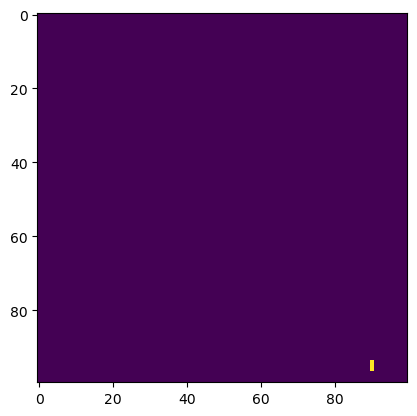

In [125]:
plt.imshow(genAttentionMask((100, 100)))

In [162]:
for e in range(3):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        attention_mask = annotation[1]
        for i in range(10):
            annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
            
            # model input
            image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
            
            # zero gradients
            optimizer.zero_grad()
            
            # forward pass
            output = model(image_cat.unsqueeze(dim=0))
            
            # loss
            l = loss(output.squeeze(dim=0), annotation_mask)
            l.backward()
            
            optimizer.step()
            epoch_loss += float(l)
            print(f"Loss: {float(l)}", end="\r")
            
            # smaller attention
            # attention_mask = output.squeeze().detach().numpy() > 0.3
            attention_mask = genAttentionMask((200, 200)) == 1
            

    print(f"\nEpoch {e}: {epoch_loss}")


C:\Users\Ankush\AppData\Local\Temp\ipykernel_13268\1621943751.py:9: RuntimeWarning: invalid value encountered in scalar divide
  if (attentionMaskSum-intersection)/attentionMaskSum > threshold:


Loss: 0.132588654756546024
Epoch 0: 39.68187162838876
Loss: 0.110229909420013434
Epoch 1: 35.72219161503017
Loss: 0.016429778188467026
Epoch 2: 29.37832918204367


torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


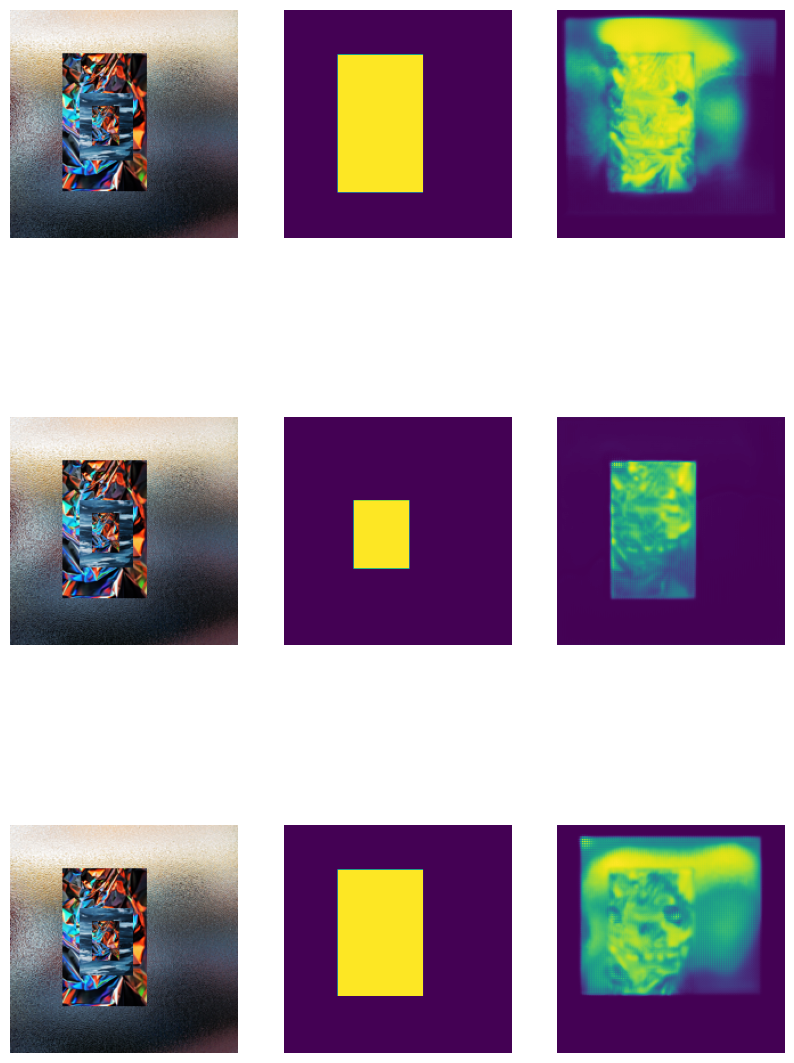

In [169]:
# model.eval()
with torch.inference_mode():
    image, annotation = val_dataset[7]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = np.zeros((200, 200))
    attention_mask[10: 150, 20: 180] = 1
    attention_mask = attention_mask == 1
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")

torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


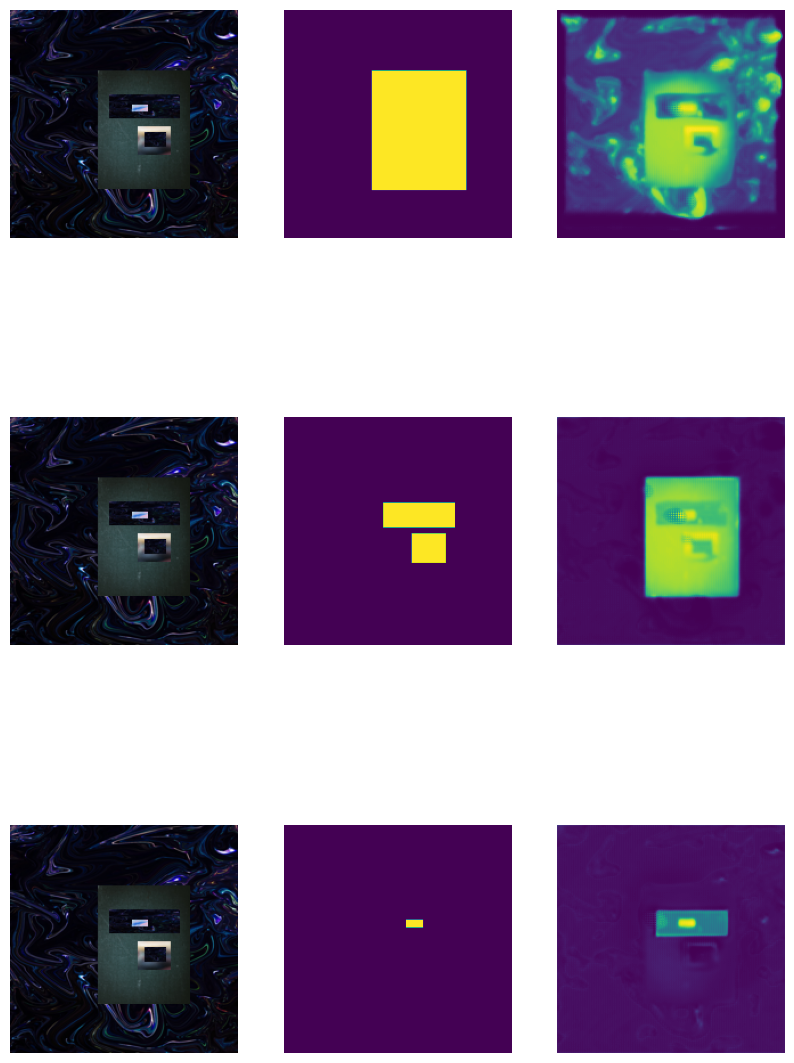

In [160]:
# model.eval()
with torch.inference_mode():
    image, annotation = train_dataset[0]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0)
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().sigmoid())
    plt.axis("off")